***A Large-Scale Dataset for Segmentation and Classification***

Authors: O. Ulucan, D. Karakaya, M. Turkan
Department of Electrical and Electronics Engineering, Izmir University of Economics, Izmir, Turkey
Corresponding author: M. Turkan
Contact Information: mehmet.turkan@ieu.edu.tr


***General Introduction***

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, 
black sea sprat, striped red mullet, trout, shrimp image samples. 

If you use this dataset in your work, please consider to cite:

@inproceedings{ulucan2020large,
  title={A Large-Scale Dataset for Fish Segmentation and Classification},
  author={Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet},
  booktitle={2020 Innovations in Intelligent Systems and Applications Conference (ASYU)},
  pages={1--5},
  year={2020},
  organization={IEEE}
}

* O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)

***Purpose of the work***

This dataset was collected in order to carry out segmentation, feature extraction and classification tasks
and compare the common segmentation, feature extraction and classification algortihms (Semantic Segmentation, Convolutional Neural Networks, Bag of Features).
All of the experiment results prove the usability of our dataset for purposes mentioned above.


***Data Gathering Equipment and Data Augmentation***

Images were collected via 2 different cameras, Kodak Easyshare Z650 and Samsung ST60. 
Therefore, the resolution of the images are 2832 x 2128, 1024 x 768, respectively.

Before the segmentation, feature extraction and classification process, the dataset was resized to 590 x 445
by preserving the aspect ratio. After resizing the images, all labels in the dataset were augmented (by flipping and rotating). 

At the end of the augmentation process, the number of total images for each class became 2000; 1000 for the RGB fish images
and 1000 for their pair-wise ground truth labels. 


***Description of the data in this data set***

The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-waise augmented ground truths.
Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".
 
For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT". 

## Training Device: GPU P100

In [7]:
import os
import random
import shutil
import glob
import logging
from tqdm import tqdm
from itertools import compress
from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from PIL import Image
import cv2 as cv
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras import saving

# !pip install gradio
# import gradio as gr


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
# setting seed for prevent different run errors
seed_value = 42  
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## 1. Explatory Data Analysis

In [3]:
fish_dataset_directory ="/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

In [4]:
def find_image_classes(images_path: str) -> List[str]:
    """
    Find subdirectory names in the specified directory.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories.

    Returns
    -------
    List[str]
        A list of subdirectory names found within the specified directory.

    Example
    -------
    classes = find_image_classes("path/to/fish_dataset_directory")
    print(classes)
    """
    return [i for i in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, i))]


In [5]:
image_classes = find_image_classes(fish_dataset_directory)
image_classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [6]:
def df_from_image_folders(images_path: str, extension: Optional[str] = "png") -> pd.DataFrame:
    """
    Create a DataFrame from image files in specified directories.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories of images.
    extension : str, optional
        The file extension of the images to include (default is "png").

    Returns
    -------
    pd.DataFrame
        A DataFrame with two columns: 'path' containing file paths and 'label' containing the class labels.

    Notes
    -----
    Excludes directories that contain 'GT' in their names.

    Example
    -------
    df = df_from_image_folders("path/to/fish_dataset_directory")
    print(df.head())
    """
    
    label = []
    path = []
    image_files = glob.glob(os.path.join(images_path, "**", f"*.{extension.lower()}"), recursive=True)

    for file in image_files:
        dirpath = os.path.dirname(file)
        folder_name = os.path.basename(dirpath)
        if "GT" not in folder_name:
            label.append(folder_name)
            path.append(file)

    class_dict = {"path": path, "label": label}
    return pd.DataFrame(class_dict)


In [7]:
df = df_from_image_folders(fish_dataset_directory)
df.head()

path  \
0  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png   
1  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00704.png   
2  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00562.png   
3  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00237.png   
4  /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00406.png   

             label  
0  Hourse Mackerel  
1  Hourse Mackerel  
2  Hourse Mackerel  
3  Hourse Mackerel  
4  Hourse Mackerel

In [8]:
def display_fish_from_each_class(df: pd.DataFrame, img_size: Tuple[int, int] = (224, 224)) -> None:
    """
    Displays one image from each unique class in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and labels.
    img_size : Tuple[int, int]
        Size to which images will be resized for display.
    """
    
    plt.figure(figsize=(12, 12))
    
    for i, unique_label in enumerate(df["label"].unique()):
        
        plt.subplot(3, 3, i + 1)
        image_path = df[df["label"] == unique_label].iloc[0, 0]
        img = load_img(image_path, target_size=img_size)
        plt.imshow(img)
        plt.title(unique_label)
        plt.axis('off')

    plt.show()

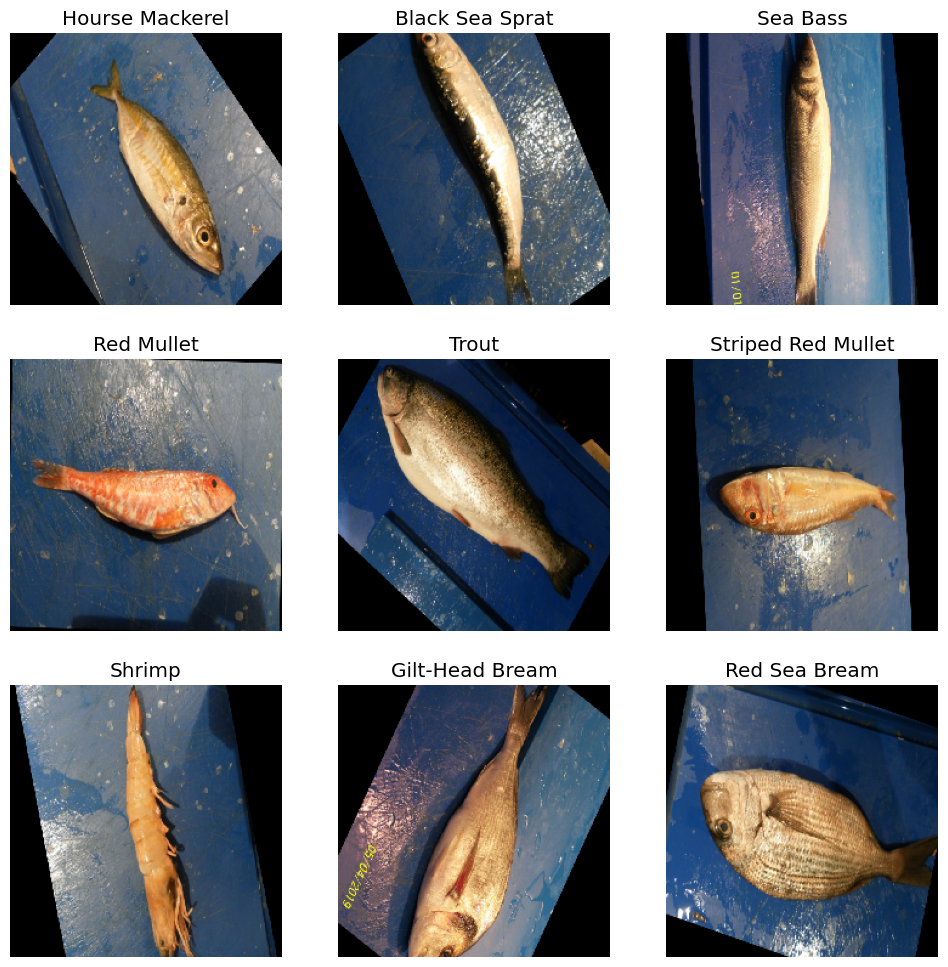

In [9]:
display_fish_from_each_class(df)

In [10]:
def display_images_from_class(df: pd.DataFrame, class_name: str, num_images: int, img_size: Tuple[int, int] = (224, 224)) -> None:
    """
    Displays a specified number of images from a given class in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and labels.
    class_name : str
        The class label to filter the images.
    img_size : Tuple[int, int]
        Size to which images will be resized for display.
    num_images : int
        Number of images to display from the given class.
    """
    images = df[df["label"] == class_name]["path"].iloc[:num_images]
    plt.figure(figsize=(12, 12))

    for i, image_path in enumerate(images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(load_img(image_path, target_size=img_size))
        plt.title(image_path[-5:-4]) 
        plt.axis('off')

    plt.show()


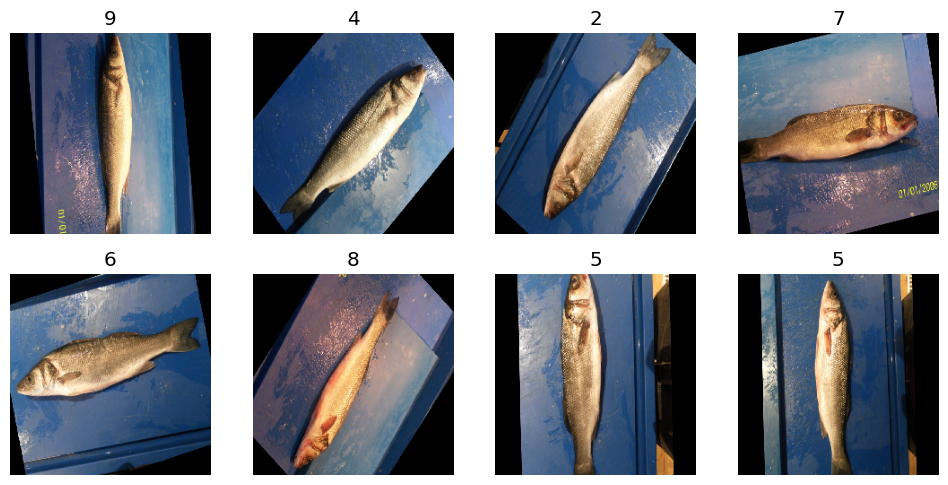

In [11]:
display_images_from_class(df, "Sea Bass", 8)

### 1.2 Görüntülerin boyutunu, renk kanallarını ve dağılımlarını analiz edilmesi

In [12]:
df["label"].nunique()

9

In [13]:
df[["label"]].value_counts()

label             
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64

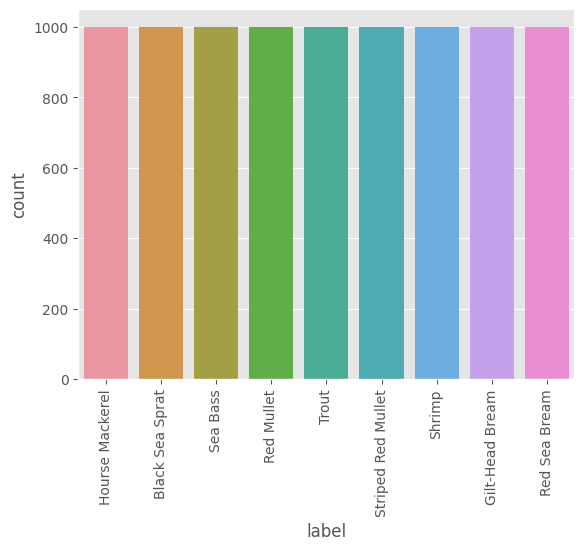

In [14]:
sns.countplot(x="label", data = df )
plt.xticks(rotation = 90)
plt.show()

**Boyut ve renk kanalları analizi yapılarak ortalama genişlik ve yükseklik değerleri belirlenip, yeniden boyutlandırma için uygun genişlik ve yükseklik değerleri seçilmiştir.**

In [15]:

def compute_image_statistics_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes average width, height, and channel count for images listed in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'path' and 'label' columns for images.

    Returns:
        pd.DataFrame: DataFrame containing average statistics for each fish class.
    """
    stats = []

    grouped = df.groupby('label')

    for label, group in grouped:
        widths = []
        heights = []
        channel_counts = []

        for _, row in group.iterrows():
            image_path = row['path']
            try:
                image = load_img(image_path)
                image_array = img_to_array(image)
                
                width, height = image.size
                widths.append(width)
                heights.append(height)
                channel_counts.append(image_array.shape[2])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
        
        if widths:  
            avg_width = np.mean(widths)
            avg_height = np.mean(heights)
            avg_channels = np.mean(channel_counts)
            min_width = np.min(widths)
            max_width = np.max(widths)
            min_height = np.min(height)
            max_height = np.max(height)

            stats.append({
                'Fish Class': label,
                'Average Width': avg_width,
                'Average Height': avg_height,
                'Average Channels': avg_channels,
                'Min Width': min_width,
                'Max Width' : max_width,
                'Min Height' : min_height,
                'Max Height' : max_height  
            })

    return pd.DataFrame(stats)


In [16]:
df_statistics = compute_image_statistics_from_df(df)
df_statistics

Fish Class  Average Width  Average Height  Average Channels  \
0     Black Sea Sprat          590.0           445.0               3.0   
1     Gilt-Head Bream          590.0           445.0               3.0   
2     Hourse Mackerel          590.0           445.0               3.0   
3          Red Mullet          590.0           445.0               3.0   
4       Red Sea Bream          590.0           445.0               3.0   
5            Sea Bass          590.0           445.0               3.0   
6              Shrimp          590.0           445.0               3.0   
7  Striped Red Mullet          590.0           445.0               3.0   
8               Trout          590.0           445.0               3.0   

   Min Width  Max Width  Min Height  Max Height  
0        590        590         445         445  
1        590        590         445         445  
2        590        590         445         445  
3        590        590         445         445  
4        590        590         445         445  
5        590        590         445         445  
6        590        590         445         445  
7        590        590         445         445  
8        590        590         445         445

In [17]:
def display_rgb_channels(image_path: str) -> None:
    """
    Displays the individual RGB channels of an image.

    Parameters
    ----------
    image_path : str
        The file path to the image.

    Returns
    -------
    None
    """
    image = Image.open(image_path)
    
    r, g, b = image.split()
    
    r_array = np.array(r)
    g_array = np.array(g)
    b_array = np.array(b)

    fig, axes = plt.subplots(1, 3, figsize=(12,12))

    axes[0].imshow(r_array, cmap="Reds")
    axes[0].set_title("Red Channel")
    axes[0].axis("off")

    axes[1].imshow(g_array, cmap="Greens")
    axes[1].set_title("Green Channel")
    axes[1].axis("off")

    axes[2].imshow(b_array, cmap="Blues")
    axes[2].set_title("Blue Channel")
    axes[2].axis("off")


    plt.show()


**Visualization of one sample image RGB colors**

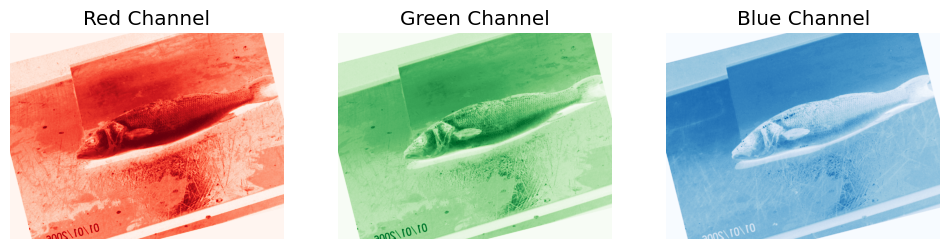

In [18]:
sample_image = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00026.png"
display_rgb_channels(sample_image)

**Average pixel distribution of the image classes**

In [19]:
def plot_average_pixel_distribution_from_df(df: pd.DataFrame, target_size: tuple = (150, 150)) -> None:
    """
    Plots average pixel value distribution for each class based on a DataFrame containing image paths and labels.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'path' and 'label' columns.
    target_size (tuple): Size to which each image will be resized (default is (150, 150)).

    Returns:
    None: Displays the average pixel value histograms for each class.
    """
    
    unique_labels = df['label'].unique()
    plt.figure(figsize=(15, 10))
 
    for i, label in enumerate(unique_labels):
       
        class_images = df[df['label'] == label]['path'].values
        pixel_values = []
      
        for image_path in class_images:
            image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image) 
            pixel_values.append(image_array)
        
        pixel_values = np.array(pixel_values)
        avg_pixel_values = np.mean(pixel_values, axis=(0, 1, 2))  
       
        plt.subplot(3, 3, i + 1) 
        plt.hist(avg_pixel_values, bins=50, range=(0, 255), color='blue', alpha=0.7)
        plt.title(f'{label} Pixel Value Distribution')
        plt.xlabel('Pixel Value (0-255)')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

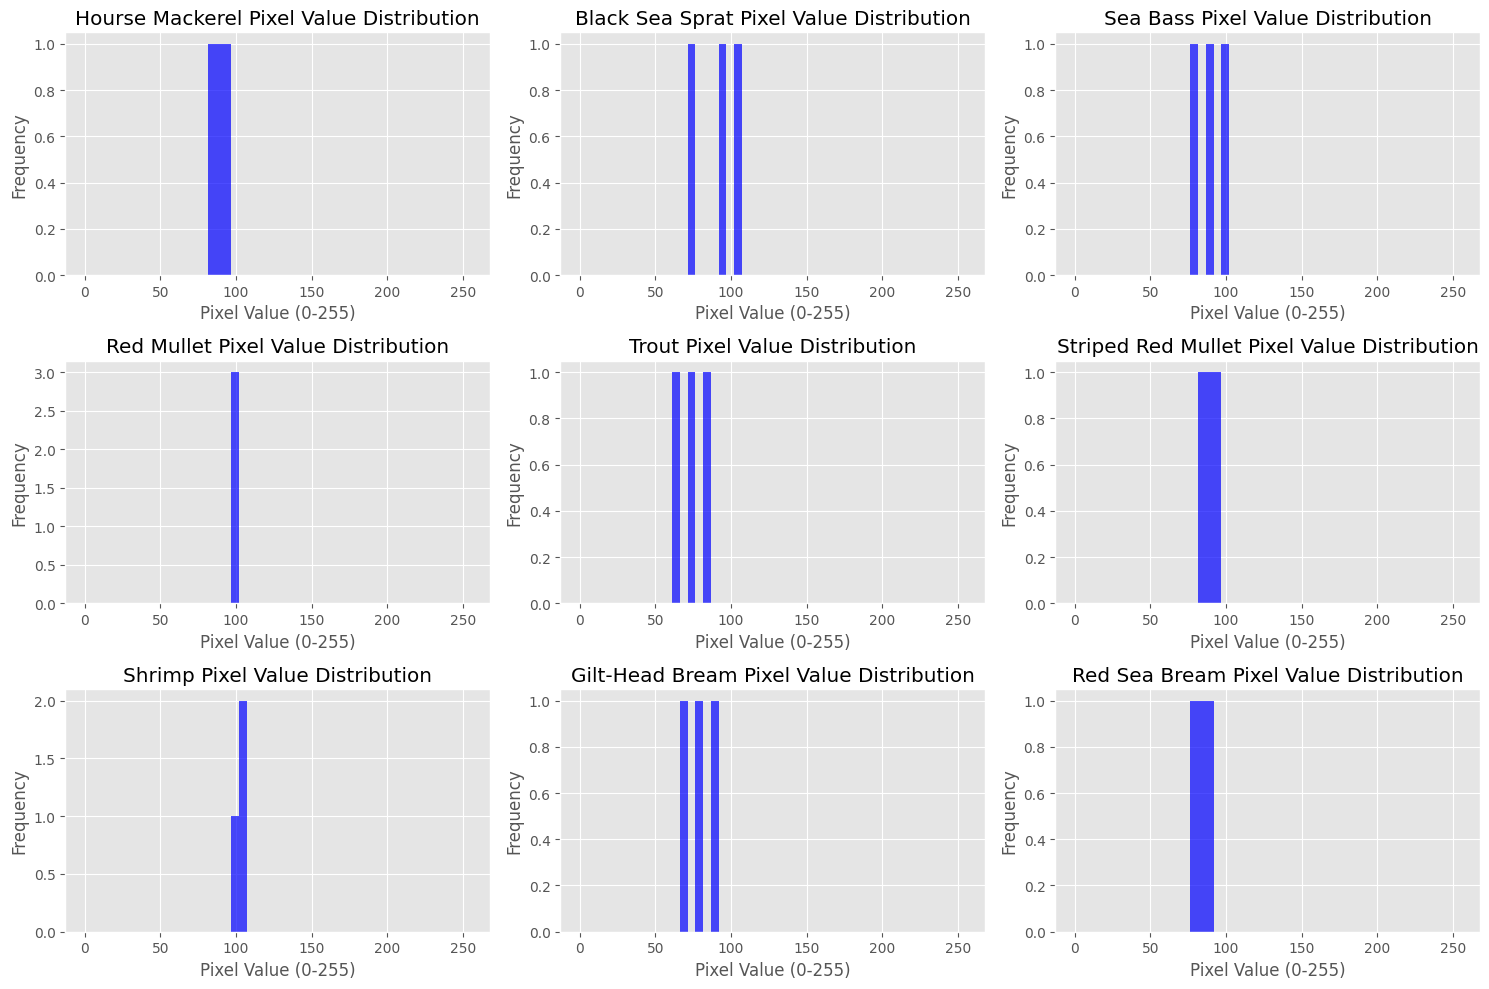

In [20]:
plot_average_pixel_distribution_from_df(df)

## 2. Performing Preprocessing Steps on Images

- **Since there are a large number of images in the dataset, preprocessing steps have been carried out to filter these images in the best possible way.**

- **Cropping, embedding, clustering, splitting, normalization, and data augmentation processes have been applied.**

- **Since all images are of the same size, a min-max resolution filter has not been applied. If these images had been scraped from the internet with different sizes, all images could have been resized to the same dimensions, and those below the threshold could have been removed from the dataset.**


**Image Cropping Demo**

**This section aims to show how smart cropping works. Smart cropping, removes the unneccessary parts of the image and focuses the main object of the image. For this purpose all images converted to PIL image** 


In [21]:
logging.basicConfig(
    level=logging.INFO, format= "%(asctime)s - %(levelname)s - %(message)s"
)


def load_image(image_path: str) -> Image.Image:
    """
    Load an image in RGB format from the given path.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    Image.Image
        Loaded image.
    """
    image = Image.open(image_path).convert("RGB")
    return image

def load_images_from_df(df: pd.DataFrame) -> List[Image.Image]:
    """
    Load images from a DataFrame containing image paths.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a column "path" for image file paths.

    Returns
    -------
    List[Image.Image]
        List of loaded images.
    """
    images = [load_image(image_path) for image_path in tqdm(df["path"].values.tolist(), total=len(df))]
    logging.info(f"Loaded {len(images)} images from DataFrame")
    return images

In [22]:
loaded_images = load_images_from_df(df)

100%|██████████| 9000/9000 [01:29<00:00, 100.48it/s]


**Image Cropping**

In [23]:
def plot_image(image: Image.Image) -> None:
    """
    Display an image using matplotlib with the axis turned off.
    
    Parameters
    ----------
    image : Image.Image
        The image to be displayed.
    
    Returns
    -------
    None
    """
    plt.imshow(image)
    plt.axis("off")
    plt.show()

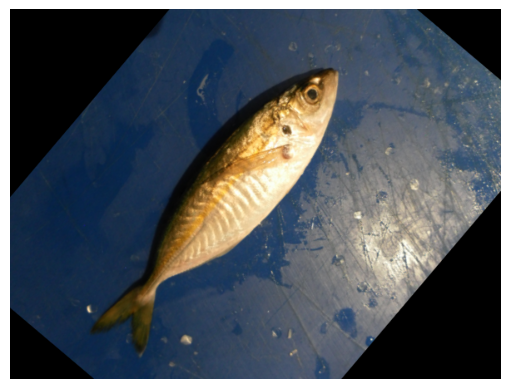

In [24]:
plot_image(loaded_images[20])

**Smart Crop Script**

In [25]:

EXTENSIONS = ("jpg", "JPG", "jpeg", "JPEG", "png", "PNG")

def detect(pil_image: Image.Image, square: bool = False) -> np.ndarray:
    """
    Detect keypoints in the image using SIFT and apply cropping.

    Parameters
    ----------
    pil_image : Image.Image
        The input image to detect keypoints and crop.
    square : bool, optional
        If True, the output image will be square-shaped. Defaults to False.
    
    Returns
    -------
    np.ndarray
        The cropped image as a numpy array.
    """
    img = np.array(pil_image) 
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)  
    sift = cv.SIFT_create(edgeThreshold=8)
    kp = sift.detect(gray, None)

    all_points = [i.pt for i in kp]
    x_points = [z[0] for z in all_points]
    y_points = [z[1] for z in all_points]
    thresh = 0
    x_min, y_min = int(min(x_points)) - thresh, int(min(y_points) - thresh)
    x_max, y_max = int(max(x_points)) + thresh, int(max(y_points) + thresh)
    min_side = min((x_max - x_min), (y_max - y_min))
    max_side = max((x_max - x_min), (y_max - y_min))
    x_mean, y_mean = int((x_max + x_min) / 2), int((y_max + y_min) / 2)

    squared_x_min, squared_x_max = x_mean - int(min_side / 2), x_mean + int(min_side / 2)
    squared_y_min, squared_y_max = y_mean - int(min_side / 2), y_mean + int(min_side / 2)

    if not square:
        return img[y_min:y_max, x_min:x_max] 

    return img[squared_y_min:squared_y_max, squared_x_min:squared_x_max] 

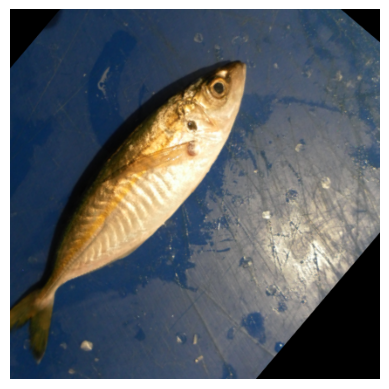

In [26]:
cropped_image = detect(loaded_images[20], square=True)
plot_image(cropped_image)

**Image Preprocessing and Saving to Disk**

Helper Functions

In [27]:
def process_image(image: Image.Image, square: bool = True) -> Image.Image:
    """
    Apply smart cropping to the image using SIFT keypoints detection.

    Parameters
    ----------
    image : Image.Image
        The image to be processed and cropped.
    square : bool, optional
        If True, the output image will be square-shaped. Defaults to True.
    
    Returns
    -------
    Image.Image
        Cropped image based on detected keypoints.
    """
    cropped_image = detect(image, square=square)
    return Image.fromarray(cropped_image)

def create_directory(dir_path: str) -> None:
    """
    Create a directory if it doesn't exist.
    
    Parameters
    ----------
    dir_path : str
        The path of the directory to create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        

def save_image(image: Image.Image, save_path: str) -> None:
    """
    Save a PIL image to a specific path.
    
    Parameters
    ----------
    image : Image.Image
        The image to save.
    save_path : str
        The path where the image should be saved.
    """
    image.save(save_path)


def process_and_save_images(df: pd.DataFrame, output_base_dir: str) -> None:
    """
    Load, process, and save images organized by labels into respective directories.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'path' and 'label' columns for images and their labels.
    output_base_dir : str
        The base directory where images will be saved, organized by labels.
    """
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        image_path = row['path']
        label = row['label']
        
        image = load_image(image_path)
        
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image) 
        if not isinstance(image, Image.Image):
            raise ValueError("Input image must be a numpy array or PIL image")
        if image.mode != "RGB":
            image = image.convert("RGB") 
        
        processed_image = process_image(image, square=True)
        
        label_dir = os.path.join(output_base_dir, label)
        create_directory(label_dir)
        
        image_name = os.path.basename(image_path) 
        save_path = os.path.join(label_dir, image_name) 
        
        save_image(processed_image, save_path)

In [28]:
output_path = "/kaggle/working/preprocessed_images"

In [29]:
process_and_save_images(df, output_path )

100%|██████████| 9000/9000 [26:47<00:00,  5.60it/s]


**Control**

In [30]:
preprocessed_images = "/kaggle/working/preprocessed_images"
df_preprocessed = df_from_image_folders(preprocessed_images)
df_preprocessed.head()


path  \
0  /kaggle/working/preprocessed_images/Black Sea Sprat/00586.png   
1  /kaggle/working/preprocessed_images/Black Sea Sprat/00856.png   
2  /kaggle/working/preprocessed_images/Black Sea Sprat/00667.png   
3  /kaggle/working/preprocessed_images/Black Sea Sprat/00593.png   
4  /kaggle/working/preprocessed_images/Black Sea Sprat/00173.png   

             label  
0  Black Sea Sprat  
1  Black Sea Sprat  
2  Black Sea Sprat  
3  Black Sea Sprat  
4  Black Sea Sprat

In [31]:
df_preprocessed["label"].value_counts()

label
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Trout                 1000
Red Mullet            1000
Red Sea Bream         1000
Striped Red Mullet    1000
Sea Bass              1000
Shrimp                1000
Name: count, dtype: int64

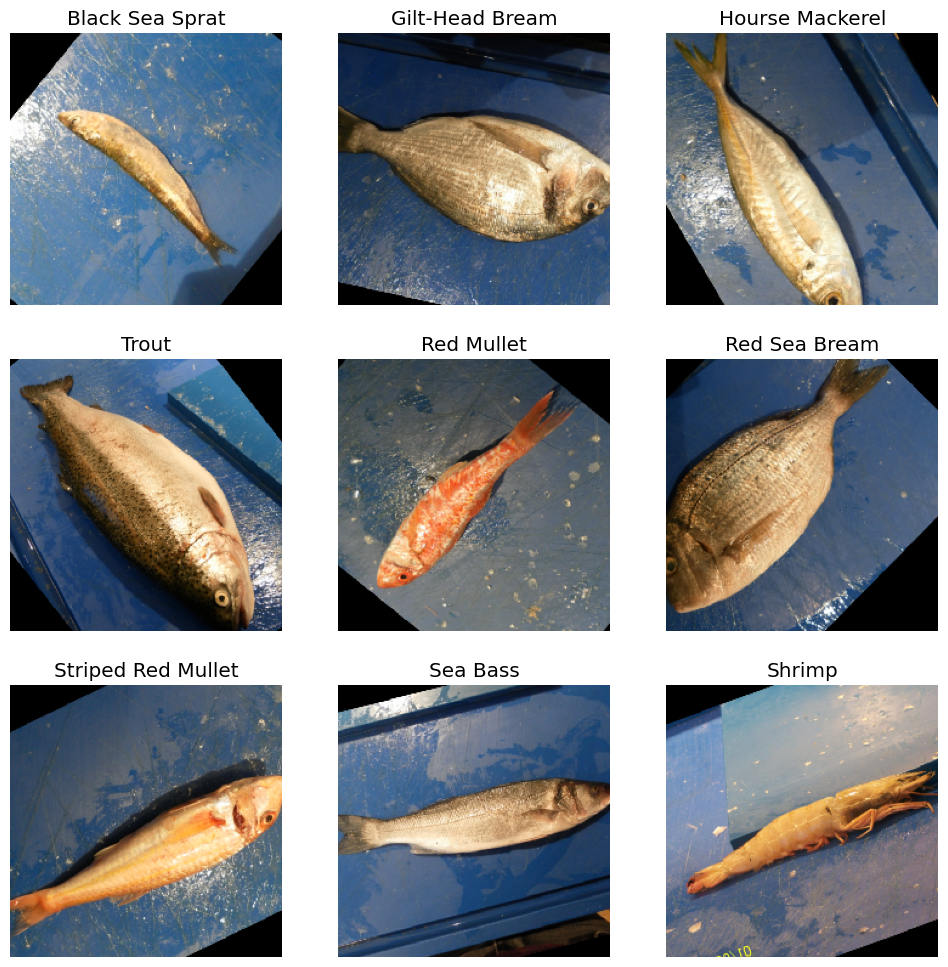

In [32]:
display_fish_from_each_class(df_preprocessed)

**Image Clustering Process**

- **Unwanted images that are not suitable for the model may be mixed in the data. Since we cannot manually check and separate a large number of images one by one, we can classify the images using unsupervised learning techniques to more easily remove these images from the dataset.**

- **To do this, we first need to extract the embeddings of the images. The ResNet50 model has been used for embedding extraction.**

- **The final softmax layer of the ResNet50 model has been removed, and the embeddings from the fully connected layer with 2048 units have been obtained. That is, the values of z = W.A + b, which pass through the activation function.**

- **Since the size of the embeddings vectors; is 2048, it is necessary to reduce the dimensions of these vectors. The more we reduce the dimensions, the more suitable the data becomes for clustering.**

- **PCA has been used for the dimensionality reduction process.**

- **It is necessary to perform standardization before PCA and K-means. However, since our data already came from ResNet in a certain standard, no additional standardization has been performed.**

- **The clustering process has been successful. The fish images have been classified according to the direction of the photo capture. However, images that will not be used in model training have not been detected as a result of the classification.**


In [33]:
class Img2VecKeras:
    def __init__(self):
        """
        Initialize the Img2VecKeras class with the ResNet50 model for embedding extraction.
        """
        base_model = ResNet50(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    
    def get_vec(self, img_paths: List[str]) -> np.ndarray:
        """
        Extract embeddings for the given list of image paths.

        Parameters
        ----------
        img_paths : List[str]
            A list of paths to the images for which embeddings are to be extracted.
        
        Returns
        -------
        np.ndarray
            An array of shape (n_samples, n_features) containing the embeddings.
        """
        embeddings = []
        for img_path in tqdm(img_paths, desc="Extracting Embeddings", unit="image"):
            img = load_image(img_path) 
            img = img.resize((224, 224)) 
            img = image.img_to_array(img)  
            img = np.expand_dims(img, axis=0)  
            img = preprocess_input(img)  
            embedding = self.model.predict(img, verbose=0)  
            embeddings.append(embedding.flatten()) 
        return np.array(embeddings)

def extract_and_save_embeddings_from_df(df: pd.DataFrame, embedding_path: str) -> None:
    """
    Extract embeddings from images using a DataFrame and save them to CSV files.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and their respective labels.
    embedding_path : str
        The directory where the extracted embeddings will be saved as CSV files.
    
    Returns
    -------
    None
    """
   
    if not os.path.exists(embedding_path):
        os.makedirs(embedding_path)

    grouped = df.groupby("label")

    for label, group in grouped:
        img_paths = group['path'].tolist()  
        
        img2vec_keras = Img2VecKeras()
        embeddings = img2vec_keras.get_vec(img_paths)

        df_embeddings = pd.DataFrame(embeddings)
        df_embeddings["filepaths"] = img_paths
        
        output_file = os.path.join(embedding_path, f"{label}_embeddings.csv")
        df_embeddings.to_csv(output_file, index=False)
        #print(f"Saved embeddings for {label} to {output_file}")


**Extract Embeddings**

In [34]:
embedding_path = "/kaggle/working/preprocessed_images_embeddings"
extract_and_save_embeddings_from_df(df_preprocessed, embedding_path)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Extracting Embeddings:   0%|          | 0/1000 [00:00<?, ?image/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1729107458.850268      84 service.cc:145] XLA service 0x7bcbd40024e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729107458.850325      84 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729107461.647888      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting Embeddings: 100%|██████████| 1000/1000 [01:19<00:00, 12.52image/s]


In [35]:
def load_embeddings_from_directory(directory: str) -> List[Tuple[np.ndarray, List[str]]]:
    """
    Load embeddings from all CSV files in the specified directory.

    Parameters
    ----------
    directory : str
        Path to the directory containing the CSV files.

    Returns
    -------
    List[Tuple[np.ndarray, List[str]]]
        A list of tuples, each containing embeddings and corresponding file paths from a CSV file.
    """
    all_embeddings = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            embeddings = pd.read_csv(file_path)
            file_paths = embeddings["filepaths"].tolist()
            embeddings = embeddings.drop("filepaths", axis=1).values
            all_embeddings.append((embeddings, file_paths))
    return all_embeddings

def calculate_pca(embeddings: np.ndarray, dim: int = 16) -> np.ndarray:
    """
    Calculate PCA for the given embeddings.

    Parameters
    ----------
    embeddings : np.ndarray
        The input embeddings to be reduced.
    dim : int
        The number of dimensions to reduce to.

    Returns
    -------
    np.ndarray
        The PCA-reduced embeddings.
    """
    print("Calculating PCA")
    pca = PCA(n_components=dim)
    pca_embeddings = pca.fit_transform(embeddings)
    print("PCA calculation done!")
    return pca_embeddings

def calculate_kmeans(embeddings: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform KMeans clustering on the embeddings.

    Parameters
    ----------
    embeddings : np.ndarray
        The input embeddings to be clustered.
    k : int
        The number of clusters.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the centroids and the labels assigned to each embedding.
    """
    print("KMeans processing...")
    centroids, labels = kmeans2(data=embeddings, k=k, minit="points")
    print("KMeans done!")
    return centroids, labels

def create_dir(directory: str) -> None:
    """
    Create a directory if it does not exist.

    Parameters
    ----------
    directory : str
        The path to the directory to create.

    Returns
    -------
    None
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

def copy_images_to_clusters(image_paths: List[str], labels: np.ndarray, cluster_range: int, class_name: str) -> None:
    """
    Copy images to their corresponding cluster directories.

    Parameters
    ----------
    image_paths : List[str]
        The list of image paths.
    labels : np.ndarray
        The labels assigned to each image by the clustering algorithm.
    cluster_range : int
        The number of clusters.
    class_name : str
        The name of the class for the output directory structure.

    Returns
    -------
    None
    """
    for label_number in tqdm(range(cluster_range)):
        label_mask = labels == label_number
        path_images = list(compress(image_paths, label_mask))
        target_directory = f"clusters/{class_name}/cluster_{label_number}"
        create_dir(target_directory)
        for image_path in path_images:
            shutil.copy2(image_path, target_directory)

def run_clustering(embeddings_dir: str, pca_dim: int = 16, cluster_range: int = 4) -> None:
    """
    Run PCA and KMeans clustering on embeddings in all CSV files within the specified directory
    and copy clustered images to respective directories.

    Parameters
    ----------
    embeddings_dir : str
        Path to the directory containing the embeddings CSV files.
    pca_dim : int
        The dimension for PCA reduction.
    cluster_range : int
        The number of clusters for KMeans.

    Returns
    -------
    None
    """
    all_embeddings = load_embeddings_from_directory(embeddings_dir)

    for index, (embeddings, image_paths) in enumerate(all_embeddings):
        class_name = os.path.basename(os.listdir(embeddings_dir)[index]).replace('.csv', '')
        pca_embeddings = calculate_pca(embeddings=embeddings, dim=pca_dim)
        centroids, labels = calculate_kmeans(pca_embeddings, k=cluster_range)
        copy_images_to_clusters(image_paths, labels, cluster_range, class_name)

**Clustering**

In [36]:
embeddings_path = "/kaggle/working/preprocessed_images_embeddings"
run_clustering(embeddings_path, pca_dim=16, cluster_range=4)

Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.22it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.13it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.52it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.53it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.79it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


Calculating PCA
PCA calculation done!
KMeans processing...
KMeans done!


100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


In [37]:

def show_images(image_paths: List[str], title: str) -> None:
    """
    Display images from the provided list of image paths.

    Parameters
    ----------
    image_paths : List[str]
        A list of paths to the images to be displayed.
    title : str
        The title for the displayed images.

    Returns
    -------
    None
    """
    # Assuming you have some image displaying logic here, e.g., using matplotlib
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=20)

    for i, image_path in enumerate(image_paths):
        img = load_img(image_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

def show_cluster_images(cluster_dir: str, cluster_count: int = 4, images_to_show: int = 5) -> None:
    """
    Display images from each cluster directory.

    Parameters
    ----------
    cluster_dir : str
        The base directory containing the cluster directories.
    cluster_count : int
        The number of clusters to display images from.
    images_to_show : int
        The number of images to display from each cluster.

    Returns
    -------
    None
    """
    for i in range(cluster_count):
        cluster_cat_dir = os.path.join(cluster_dir, f'cluster_{i}')
        cluster_cat_files = os.listdir(cluster_cat_dir)
        cluster_images_to_show_cat = [os.path.join(cluster_cat_dir, img_file) for img_file in cluster_cat_files[:images_to_show]]
        show_images(cluster_images_to_show_cat, f'Cluster {i}')




**Control Cluster Images**

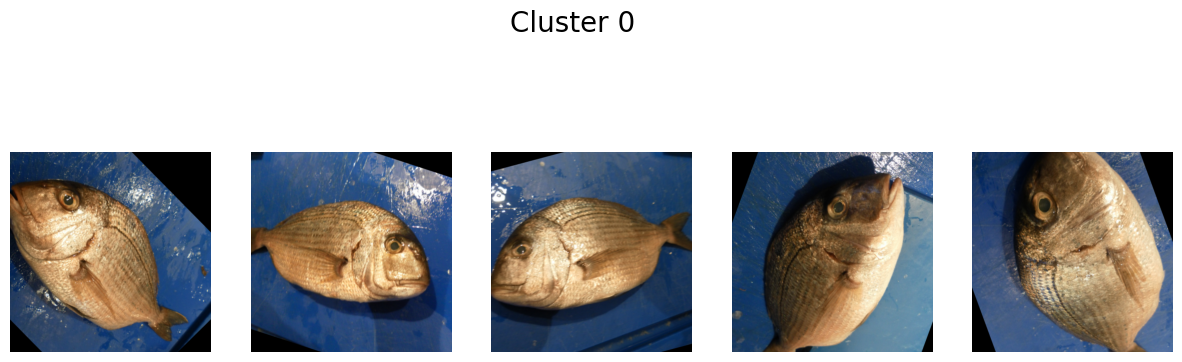

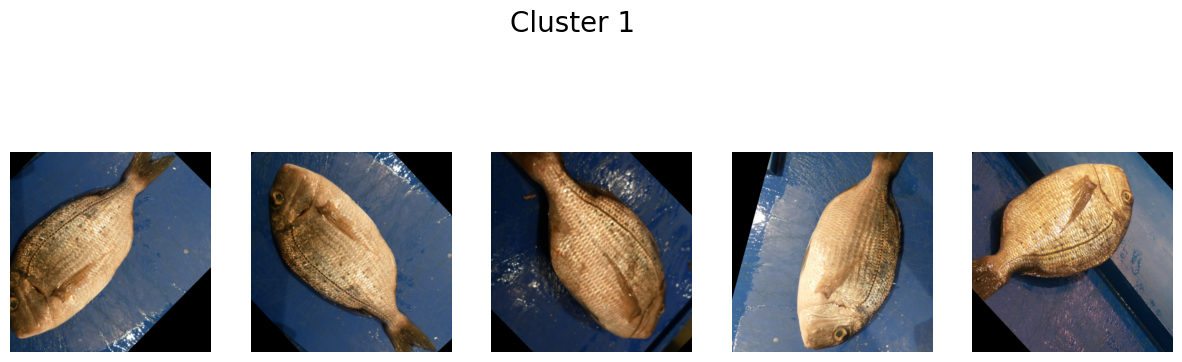

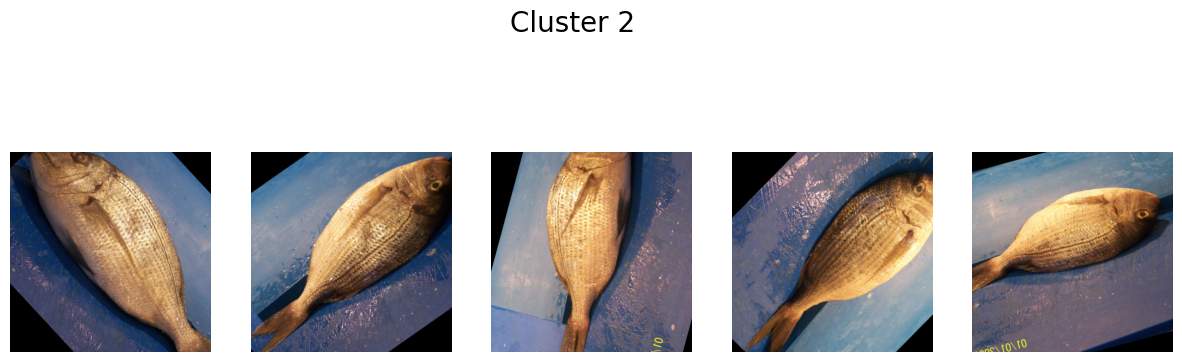

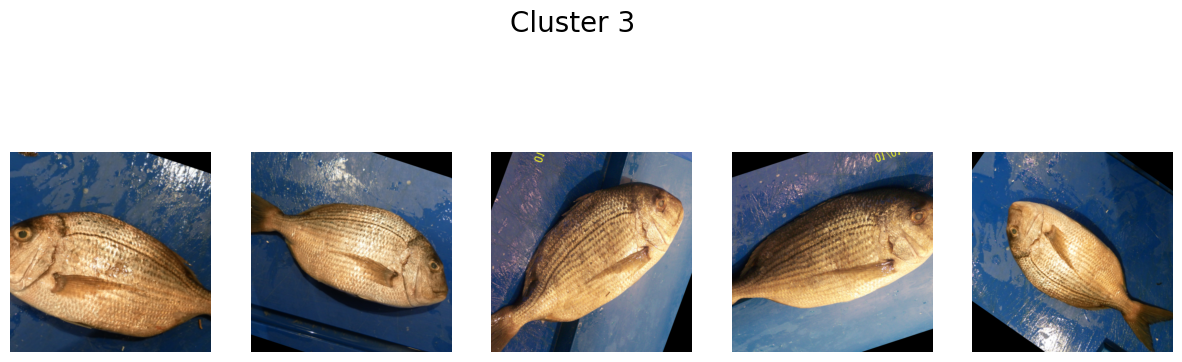

In [38]:
show_cluster_images('/kaggle/working/clusters/Red Sea Bream_embeddings', cluster_count=4, images_to_show=5)

## 3. Creating the Deep Learning (ANN) Model

### 3.1. Splitting the Fish_Dataset into Train, Validation, and Test Sets
- **To use for validation during model training, 10% of the dataset has been set aside as the validation set. After the model training is completed, a test set has been created to evaluate the performance.**


In [39]:
def copy_images(subset_df: pd.DataFrame, target_dir: str) -> None:
    """
    Copies images from the DataFrame to the specified target directory.

    Parameters:
    - subset_df (pd.DataFrame): A DataFrame containing image paths in the 'path' column.
    - target_dir (str): The target directory where the images will be copied.

    Returns:
    - None: This function does not return any value.
    """
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc=f"Copying images to {target_dir}"):
        shutil.copy2(row['path'], target_dir)


def split_data_into_train_val_test(
    df_processed: pd.DataFrame, 
    output_dir: str, 
    train_ratio: float = 0.8, 
    val_ratio: float = 0.1, 
    test_ratio: float = 0.1,
    random_seed: int = 42 
) -> pd.DataFrame:
    """
    Splits dataset images into train, validation, and test sets based on fixed ratio for each class.

    Parameters:
    - df_processed (pd.DataFrame): DataFrame containing 'path' and 'label' columns for images.
    - output_dir (str): Directory where the train/validation/test folders will be created.
    - train_ratio (float): Proportion of data to allocate to the train set.
    - val_ratio (float): Proportion of data to allocate to the validation set.
    - test_ratio (float): Proportion of data to allocate to the test set.

    Returns:
    - pd.DataFrame: A DataFrame summarizing the counts of images in each set (train/val/test) per class.
    """
    
    # I want to get same results for each notebook run.
    np.random.seed(random_seed)
  
    df_processed = shuffle(df_processed).reset_index(drop=True)
    class_summary = {'Class': [], 'Train Count': [], 'Validation Count': [], 'Test Count': []}
    
   
    for class_name, class_group in df_processed.groupby('label'):
        
        total_images = len(class_group)
        train_count = int(total_images * train_ratio)
        val_count = int(total_images * val_ratio)
        test_count = total_images - train_count - val_count 

        class_summary['Class'].append(class_name)
        class_summary['Train Count'].append(train_count)
        class_summary['Validation Count'].append(val_count)
        class_summary['Test Count'].append(test_count)

        train_df = class_group[:train_count]
        val_df = class_group[train_count:train_count + val_count]
        test_df = class_group[train_count + val_count:]
        
        train_dir = os.path.join(output_dir, 'train', class_name)
        val_dir = os.path.join(output_dir, 'validation', class_name)
        test_dir = os.path.join(output_dir, 'test', class_name)
        
        for dir_path in [train_dir, val_dir, test_dir]:
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
        
        copy_images(train_df, train_dir)
        copy_images(val_df, val_dir)
        copy_images(test_df, test_dir)
    
    summary_df = pd.DataFrame(class_summary)
    
    return summary_df

In [40]:
model_images_output = "/kaggle/working/model_dataset"
summary_df = split_data_into_train_val_test(df_preprocessed, model_images_output)

summary_df

Copying images to /kaggle/working/model_dataset/train/Black Sea Sprat: 100%|██████████| 800/800 [00:00<00:00, 2055.59it/s]
Copying images to /kaggle/working/model_dataset/validation/Black Sea Sprat: 100%|██████████| 100/100 [00:00<00:00, 2140.41it/s]
Copying images to /kaggle/working/model_dataset/test/Black Sea Sprat: 100%|██████████| 100/100 [00:00<00:00, 2181.65it/s]
Copying images to /kaggle/working/model_dataset/train/Gilt-Head Bream: 100%|██████████| 800/800 [00:00<00:00, 1980.07it/s]
Copying images to /kaggle/working/model_dataset/validation/Gilt-Head Bream: 100%|██████████| 100/100 [00:00<00:00, 2066.41it/s]
Copying images to /kaggle/working/model_dataset/test/Gilt-Head Bream: 100%|██████████| 100/100 [00:00<00:00, 1991.20it/s]
Copying images to /kaggle/working/model_dataset/train/Hourse Mackerel: 100%|██████████| 800/800 [00:04<00:00, 173.73it/s]
Copying images to /kaggle/working/model_dataset/validation/Hourse Mackerel: 100%|██████████| 100/100 [00:00<00:00, 163.54it/s]
Copyi

Class  Train Count  Validation Count  Test Count
0     Black Sea Sprat          800               100         100
1     Gilt-Head Bream          800               100         100
2     Hourse Mackerel          800               100         100
3          Red Mullet          800               100         100
4       Red Sea Bream          800               100         100
5            Sea Bass          800               100         100
6              Shrimp          800               100         100
7  Striped Red Mullet          800               100         100
8               Trout          800               100         100

### 3.2. Data augmentation

- **Normalization**: Rescaling pixel values from the range of 0-255 to 0-1.
- **Random Rotation**: Rotating images up to 40 degrees randomly.
- **Random Width and Height Shift**: Shifting images randomly by 20% of their width and height.
- **Random Shear**: Applying random shearing transformations with a shear intensity of 0.2.
- **Random Zoom**: Zooming in on images randomly by 20%.
- **Horizontal Flip**: Flipping images horizontally.
- **Fill Method**: Using the 'nearest' fill mode for newly created pixels during transformations.

In [41]:
train_dir = '/kaggle/working/model_dataset/train'  
validation_dir = '/kaggle/working/model_dataset/validation'

In [42]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=40,       
    width_shift_range=0.2,    
    height_shift_range=0.2,
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'   
)


val_datagen = ImageDataGenerator(rescale=1./255) 

# load train images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # resizing
    batch_size=32,
    class_mode='binary'      # binary classification (cat, dog)
)

# load validation images
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),  
    batch_size=32,
    class_mode='binary'   
)

class_indices = train_generator.class_indices
print("Class labels:", class_indices)

Found 7200 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Class labels: {'Black Sea Sprat': 0, 'Gilt-Head Bream': 1, 'Hourse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}


**Data augmentation Control**

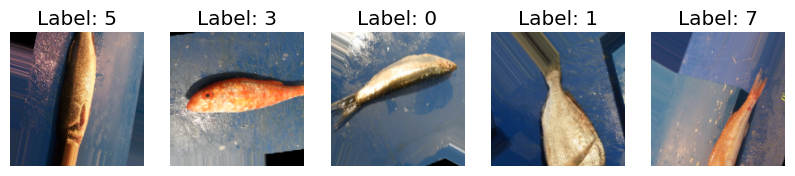

In [43]:
batch = next(train_generator)
images, labels = batch
num_images = min(5, len(images))

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i]) 
    plt.title(f"Label: {int(labels[i])}")  
    plt.axis('off') 
plt.show()

### 3.3. Model Selection and Evaluation

**The following operations have been performed:**

- **Selection of the deep learning model.**
- **Using the training and validation datasets to train the selected model. Dropout and batch normalization are applied to prevent overfitting.**
- **Determining the necessary hyperparameters.**
- **Select best model (it changes every run).**

**The deep learning architecture will utilize ANN (Artificial Neural Network). To achieve better results, CNN layers or pre-trained models like ResNet or EfficientNet can be fine-tuned using transfer learning methods. In this case study, an ANN model has been created.**

**Using Class Structure with Keras Functional API**
- The Functional API offers the ability to customize model architecture in a more detailed and flexible way. This is especially useful when creating more complex and customized network structures.
  
- More complex models may require features like multiple inputs and outputs, shared layers, or skip connections. The Functional API provides the necessary flexibility to manage such architectures.
  
- Using the Functional API in model design allows for gaining experience in working with more complex structures. This helps develop a habit for building more advanced network architectures in the future. This way, one can master a broader range of models without being limited to the Sequential API.



In [44]:
@saving.register_keras_serializable()
class CustomANN(Model):
    def __init__(self, input_shape=(150, 150, 3), num_classes=9, name="custom_ann", **kwargs):
        super(CustomANN, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes

        # Flatten layer converts 2D images to 1D
        self.flatten = Flatten()

        # Fully connected layers
        self.fc1 = Dense(512, activation='relu')
        self.bn1 = BatchNormalization()  
        self.drop1 = Dropout(0.5)
        
        self.fc2 = Dense(256, activation='relu')
        self.bn2 = BatchNormalization()  
        self.drop2 = Dropout(0.4)
        
        self.fc3 = Dense(128, activation='relu')
        self.bn3 = BatchNormalization()  
        self.drop3 = Dropout(0.3)

        self.fc4 = Dense(num_classes, activation='softmax')  

    def call(self, inputs, training=False):
        x = self.flatten(inputs)
        x = self.fc1(x)
        x = self.bn1(x, training=training)  
        x = self.drop1(x, training=training)
        
        x = self.fc2(x)
        x = self.bn2(x, training=training)  
        x = self.drop2(x, training=training)
        
        x = self.fc3(x)
        x = self.bn3(x, training=training)  
        x = self.drop3(x, training=training)
        
        outputs = self.fc4(x)  
        return outputs

    def get_config(self):
        config = super(CustomANN, self).get_config()
        config.update({
            "input_shape": (150, 150, 3),
            "num_classes": self.num_classes
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def train(self, train_dir, val_dir, batch_size=32, epochs=10):
        
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        validation_datagen = ImageDataGenerator(rescale=1./255)
        
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
        )
        
        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
        )
        
        checkpoint_callback = ModelCheckpoint(
            filepath='/kaggle/working/models/model_checkpoint_{epoch:02d}.keras',  
            monitor='val_loss',
            save_best_only=True,  
            save_weights_only=False,
            mode='min',
            verbose=1
        )

  
        early_stopping_callback = EarlyStopping(
            monitor='val_loss',
            patience=5,  
            verbose=1
        )
        
      
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        
        optimizer = Adam(learning_rate=0.001)
        
        self.compile(optimizer=optimizer,
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
        
        history = self.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[checkpoint_callback, tensorboard_callback, early_stopping_callback],
        )
        
        return history

In [45]:
train_dir = "/kaggle/working/model_dataset/train"
val_dir = "/kaggle/working/model_dataset/validation"

model = CustomANN(input_shape=(150, 150, 3), num_classes=9)
result = model.train(train_dir=train_dir, val_dir=val_dir, batch_size=32, epochs=50)

Found 7200 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.1736 - loss: 2.6486

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 2.31525, saving model to /kaggle/working/models/model_checkpoint_01.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 111s 445ms/step - accuracy: 0.1738 - loss: 2.6476 - val_accuracy: 0.3044 - val_loss: 2.3153
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.2685 - loss: 2.0640
Epoch 2: val_loss improved from 2.31525 to 1.57064, saving model to /kaggle/working/models/model_checkpoint_02.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 112s 486ms/step - accuracy: 0.2685 - loss: 2.0638 - val_accuracy: 0.4278 - val_loss: 1.5706
Epoch 3/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.2835 - loss: 1.9348
Epoch 3: val_loss did not improve from 1.57064
225/225 ━━━━━━━━━━━━━━━━━━━━ 104s 450ms/step - accuracy: 0.2836 - loss: 1.9344 - val_accuracy: 0.4111 - val_loss: 1.5717
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.3054 - loss: 1.8331
Epoch 4: val_loss improved from 1.57064 to 1.51760, saving model to /kaggle/working/models/mode

**Best Model ="/kaggle/working/models/model_checkpoint_23.keras"**

In [46]:
model.summary()

Model: "custom_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,184,861 (397.43 MB)

 Trainable params: 34,727,689 (132.48 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 69,455,380 (264.95 MB)

**Visualize with Tensorboard**

In [47]:
# %tensorboard --logdir logs/fit

**Visualize with History**

In [48]:
def plot_training_history(result: Dict[str, list]) -> None:
    """
    Plots the training and validation loss and accuracy graphs from the model's training history.

    Parameters:
    -----------
    result : Dict[str, list]
        A dictionary containing the history of the model's training and validation metrics. 
        It should include at least the following keys:
        - 'loss': List of training loss values.
        - 'val_loss': List of validation loss values.
        - 'accuracy': List of training accuracy values.
        - 'val_accuracy': List of validation accuracy values.

    Returns:
    --------
    None
        This function does not return any value, it just displays the plots.
    """
    
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(result.history['loss'], label='Train Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(result.history['accuracy'], label='Train Accuracy')
    plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

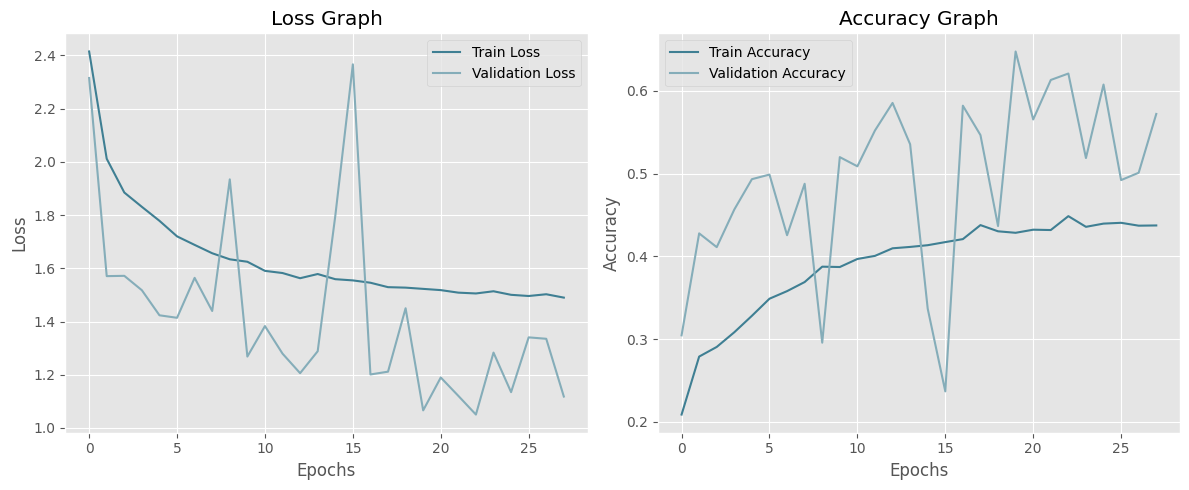

In [49]:
plot_training_history(result)

**Evaluation**

The following tasks have been carried out:

- After training is completed, the model's performance is evaluated on the test set.
  
- The performance of the model is analyzed using metrics such as classification accuracy, confusion matrix, accuracy, precision, and recall.
  
- Errors are examined by visualizing the examples that the model misclassified.

**After the test data is formatted appropriately and predictions are made, the performance metrics have been calculated.**

**The best model has been selected and loaded.**


In [51]:
# model = load_model("/kaggle/working/models/model_checkpoint_23.keras")

**Since there is no class imbalance, an averaging method that gives equal importance to each class can be preferred. In this case, `average='macro'` would be appropriate on precission and recall score.**


In [60]:
def evaluate_model(
    model, 
    test_dir: str, 
    target_size: tuple = (150, 150), 
    batch_size: int = 32
) -> None:
    """
    Evaluate the model on the test dataset and display performance metrics.

    Parameters:
    model: The trained model to evaluate.
    test_dir (str): Directory path to the test dataset.
    target_size (tuple): Target size for the input images (height, width).
    batch_size (int): Number of images to process in each batch.

    Returns:
    None: This function prints the accuracy, precision, recall, and displays
          confusion matrix and classification report.
    """

 
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False
    )

    predictions = model.predict(test_generator)

    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = test_generator.classes

    # Performance Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='macro')  # Macro, eşit sınıf dağılımı için ideal
    recall = recall_score(true_classes, predicted_classes, average='macro')  # Macro, eşit sınıf dağılımı için ideal

    print("Accuracy:", accuracy)
    print("Precision (macro):", precision)
    print("Recall (macro):", recall)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Classification Report
    print(classification_report(true_classes, predicted_classes))
    
    return test_generator ,predicted_classes


Found 900 images belonging to 9 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step
Accuracy: 0.5855555555555556
Precision (macro): 0.5626980054498413
Recall (macro): 0.5855555555555555


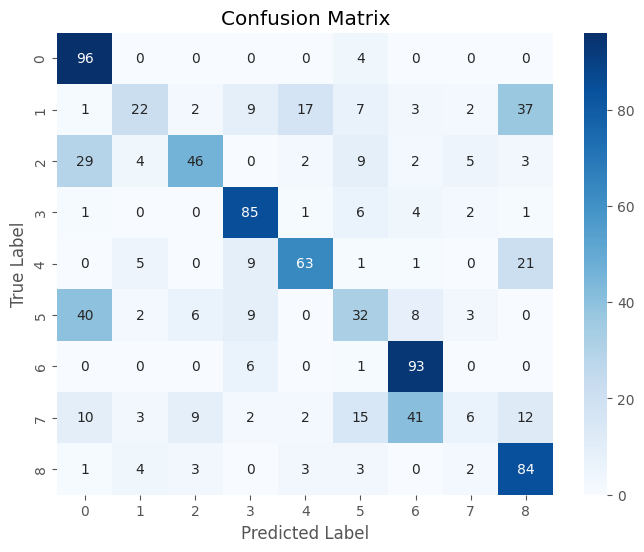

              precision    recall  f1-score   support

           0       0.54      0.96      0.69       100
           1       0.55      0.22      0.31       100
           2       0.70      0.46      0.55       100
           3       0.71      0.85      0.77       100
           4       0.72      0.63      0.67       100
           5       0.41      0.32      0.36       100
           6       0.61      0.93      0.74       100
           7       0.30      0.06      0.10       100
           8       0.53      0.84      0.65       100

    accuracy                           0.59       900
   macro avg       0.56      0.59      0.54       900
weighted avg       0.56      0.59      0.54       900



In [61]:
# test_directory = "/kaggle/working/model_dataset/test"
# test_generator, predicted_classes = evaluate_model(model, test_directory)

**Analyze Misclassifications**

In [62]:
def analyze_and_visualize_misclassifications(test_generator, predicted_classes, num_samples=10) -> None:
    """
    Analyze and visualize misclassified images from the test dataset.

    Parameters:
    test_generator: The generator used to load the test data.
    predicted_classes: The predicted class indices from the model.
    num_samples: The number of misclassified images to display.

    Returns:
    None: This function prints the total number of misclassified images and shows a plot of some misclassified examples.
    """
    
    test_generator.reset()

    df = pd.DataFrame({
        'filename': test_generator.filenames,
        'predict': predicted_classes,  
        'y': test_generator.classes
    })
    misclassified = df[df['y'] != df['predict']]
    total_misclassified = misclassified.shape[0]
    
    print(f'Total misclassified images: {total_misclassified}')
    print("\nMisclassified Images:")
    print(misclassified)

    if total_misclassified > 0:
   
        samples_to_display = min(num_samples, total_misclassified)
        misclassified_samples = misclassified.sample(samples_to_display)
        
        cols = 5
        rows = (samples_to_display + cols - 1) // cols 
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        
        for ax, (_, row) in zip(axes.flatten(), misclassified_samples.iterrows()):
            img_path = test_generator.directory + '/' + row['filename']
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(f'True: {row["y"]}, Pred: {row["predict"]}')
            ax.axis('off')

        for i in range(samples_to_display, len(axes.flatten())):
            axes.flatten()[i].axis('off')

        plt.tight_layout()
        plt.show()

Total misclassified images: 373

Misclassified Images:
                      filename  predict  y
29   Black Sea Sprat/00242.png        5  0
30   Black Sea Sprat/00248.png        5  0
32   Black Sea Sprat/00254.png        5  0
65   Black Sea Sprat/00524.png        5  0
100  Gilt-Head Bream/00004.png        5  1
..                         ...      ... ..
840            Trout/00367.png        2  8
843            Trout/00423.png        4  8
852            Trout/00533.png        1  8
853            Trout/00537.png        1  8
883            Trout/00824.png        5  8

[373 rows x 3 columns]


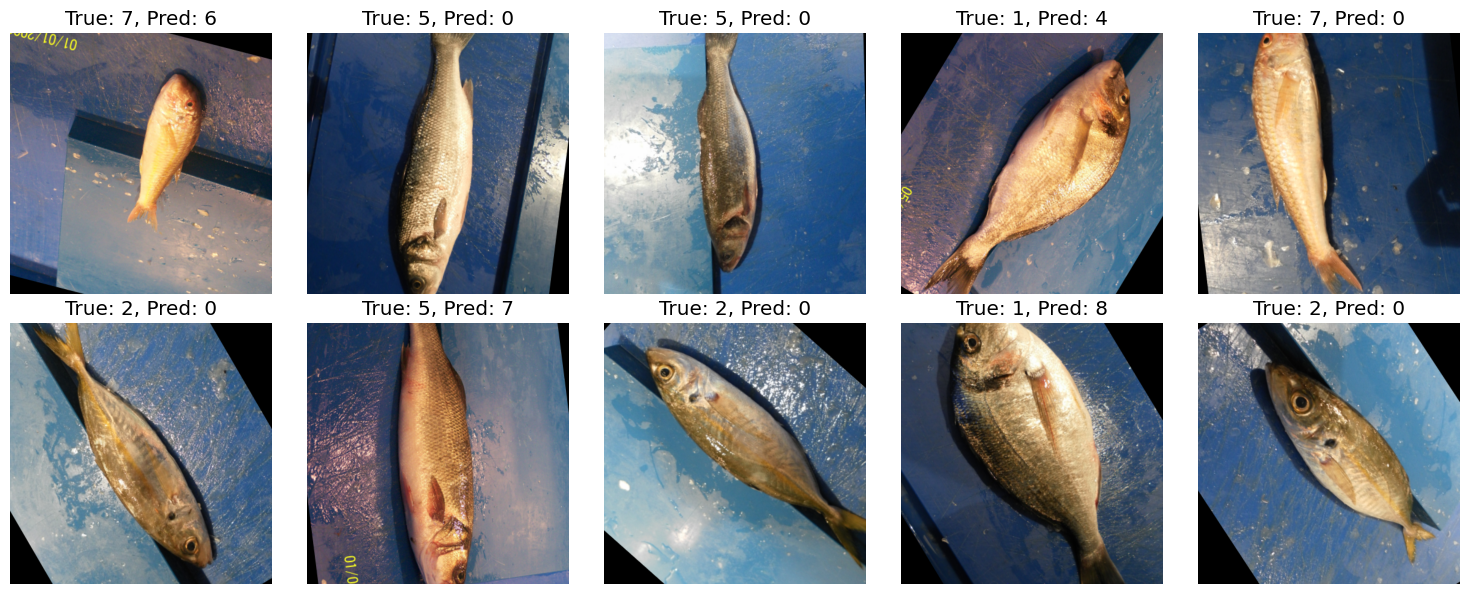

In [63]:
# analyze_and_visualize_misclassifications(test_generator, predicted_classes, num_samples=10)

**Prediction**

In [4]:
def predict_single_image(model, image_path, test_generator):
    """
    Predict the class of a single image using a trained model.

    Parameters:
    model: The trained Keras model for image classification.
    image_path: Path to the image to be classified.
    test_generator: Keras ImageDataGenerator flow generator.

    Returns:
    None: This function displays the image and prints the predicted class with confidence.
    """
    image = load_img(image_path, target_size=(150, 150))
    plt.imshow(image)
    plt.title(f"Selected Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()
   
    image_array = img_to_array(image) / 255.0 
    image_array = np.expand_dims(image_array, axis=0)  

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions, axis=1)[0] 

    class_indices = test_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()} 

    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})")


In [5]:
# selected_image_1 = "/kaggle/working/model_dataset/test/Sea Bass/00663.png"
# predict_single_image(model, selected_image_1, test_generator)

NameError: name 'model' is not defined

In [2]:
# selected_image_2 = "/kaggle/working/model_dataset/test/Red Mullet/00464.png"
# predict_single_image(model, selected_image_2, test_generator)

NameError: name 'predict_single_image' is not defined

### 4. Deployment(Web Application)

**Web app created but it is not working on kaggle**


In [72]:
# def predict(image):
#     """
#     Predict the class of a single image using a trained model.

#     Parameters:
#     image: The uploaded image.

#     Returns:
#     tuple: A tuple containing the predicted class label and confidence.
#     """

#     image = image.resize((150, 150))

#     image_array = img_to_array(image) / 255.0  
#     image_array = np.expand_dims(image_array, axis=0) 

#     predictions = model.predict(image_array)
#     predicted_index = np.argmax(predictions, axis=1)[0]

#     class_indices = test_generator.class_indices
#     class_labels = {v: k for k, v in class_indices.items()}

#     predicted_label = class_labels[predicted_index]
#     confidence = predictions[0][predicted_index]

#     return predicted_label, confidence

In [1]:

# interface = gr.Interface(
#     fn=predict,  
#     inputs=gr.Image(type="pil", label="Upload Image"),
#     outputs=[gr.Textbox(label="Predicted Label"), gr.Number(label="Confidence")], 
#     title="Multi-class Image Classifier", 
#     description="Upload an image to classify it and see the confidence value." 
# )


# interface.launch(share= True)

In [ ]:
# if os.path.exists("/kaggle/working/models"):
#     shutil.rmtree("/kaggle/working/models")  # Klasörü ve içindeki her şeyi sil
#     print(f"{output_path} has been deleted.")
# else:
#     print(f"{output_path} does not exist.")